## Abstract

In this work I'm concetrated on math exam scores both 4th and 8th grade. I found the main influence on score have YEAR of exam, everage money spend on one student (in my dataset asigned as AVERAGE) and the STATE where students are examed. Depanding on model (linear or random forest) AVERAGE cash play high role or STATE.

## Loading libraries and data file

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
import warnings
warnings.filterwarnings('ignore')

In [3]:
df=pd.read_csv('USdata.csv')

In [4]:
df.isna().sum()*100/df.shape[0]

PRIMARY_KEY                      0.000000
STATE                            0.000000
YEAR                             0.000000
ENROLL                          28.629738
TOTAL_REVENUE                   25.655977
FEDERAL_REVENUE                 25.655977
STATE_REVENUE                   25.655977
LOCAL_REVENUE                   25.655977
TOTAL_EXPENDITURE               25.655977
INSTRUCTION_EXPENDITURE         25.655977
SUPPORT_SERVICES_EXPENDITURE    25.655977
OTHER_EXPENDITURE               28.629738
CAPITAL_OUTLAY_EXPENDITURE      25.655977
GRADES_PK_G                     10.087464
GRADES_KG_G                      4.839650
GRADES_4_G                       4.839650
GRADES_8_G                       4.839650
GRADES_12_G                      4.839650
GRADES_1_8_G                    40.524781
GRADES_9_12_G                   37.551020
GRADES_ALL_G                     4.839650
AVG_MATH_4_SCORE                67.055394
AVG_MATH_8_SCORE                64.897959
AVG_READING_4_SCORE             62

Quick look what is going on in the data. On ecan see two main groups of data
1.  revenue and expenditure 
1.  exams
1. Correlation between revenue/expenditure and grades suggest if there are more students than there is more maney for the state for them.

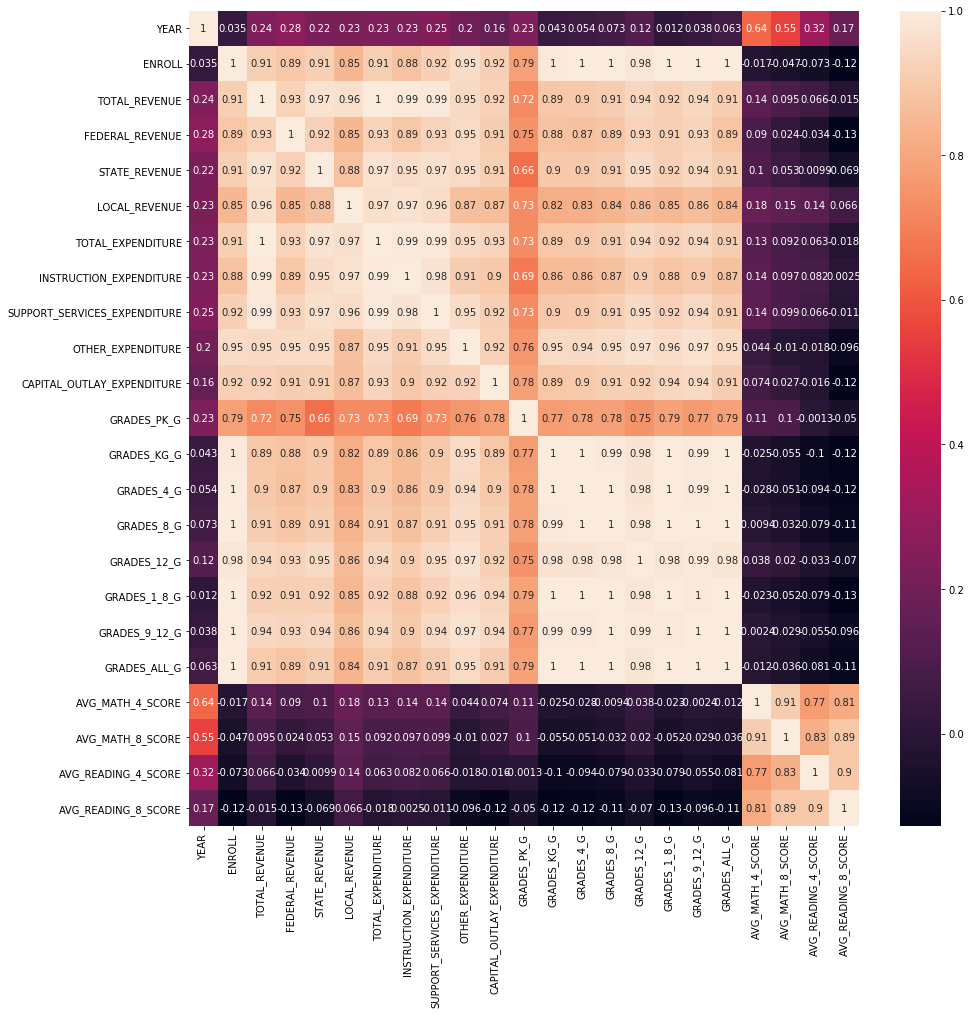

In [5]:

corr = df.corr()
fig, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(corr, annot=True,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

## Let's see what is the influence of state name on the revenue

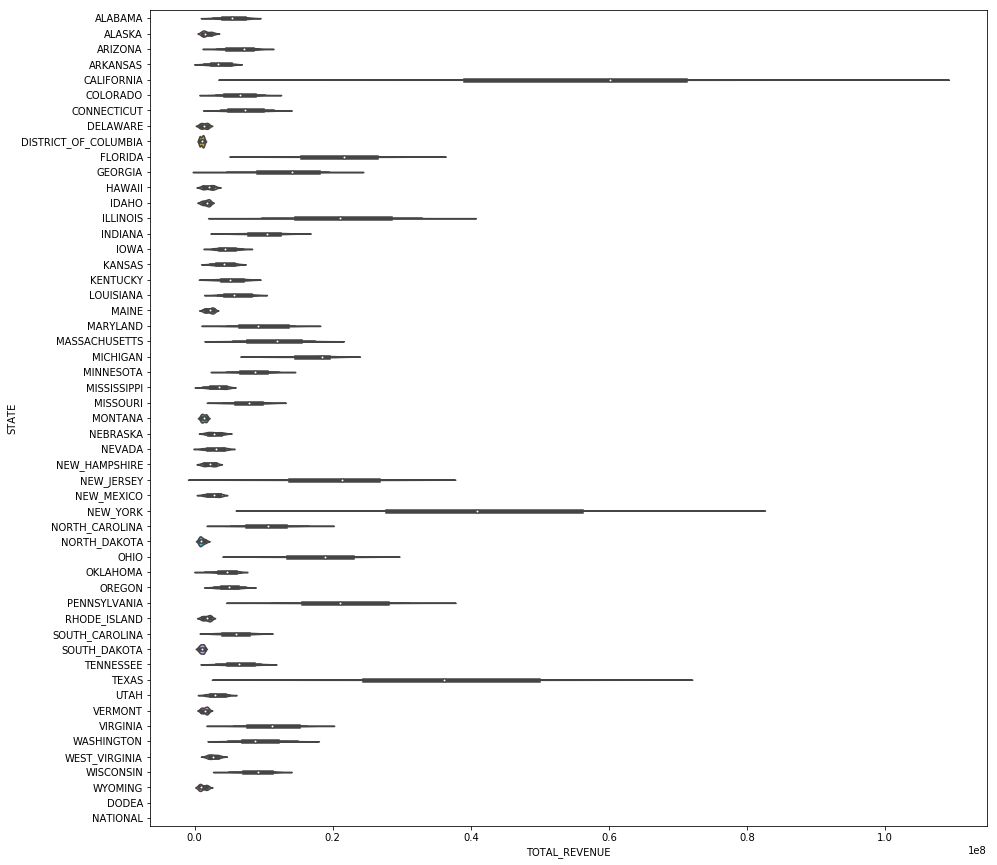

In [6]:
fig, ax = plt.subplots(figsize=(15, 15))
sns.violinplot(x="TOTAL_REVENUE", y="STATE", data=df)

In [7]:
df['average_reveneue']=df['TOTAL_REVENUE']/df['GRADES_ALL_G']
df['average_expenditure']=df['TOTAL_EXPENDITURE']/df['GRADES_ALL_G']

## Now let's take TOTAL_REVENUE/GRADES_ALL_G what means we have more equality, but not perfect

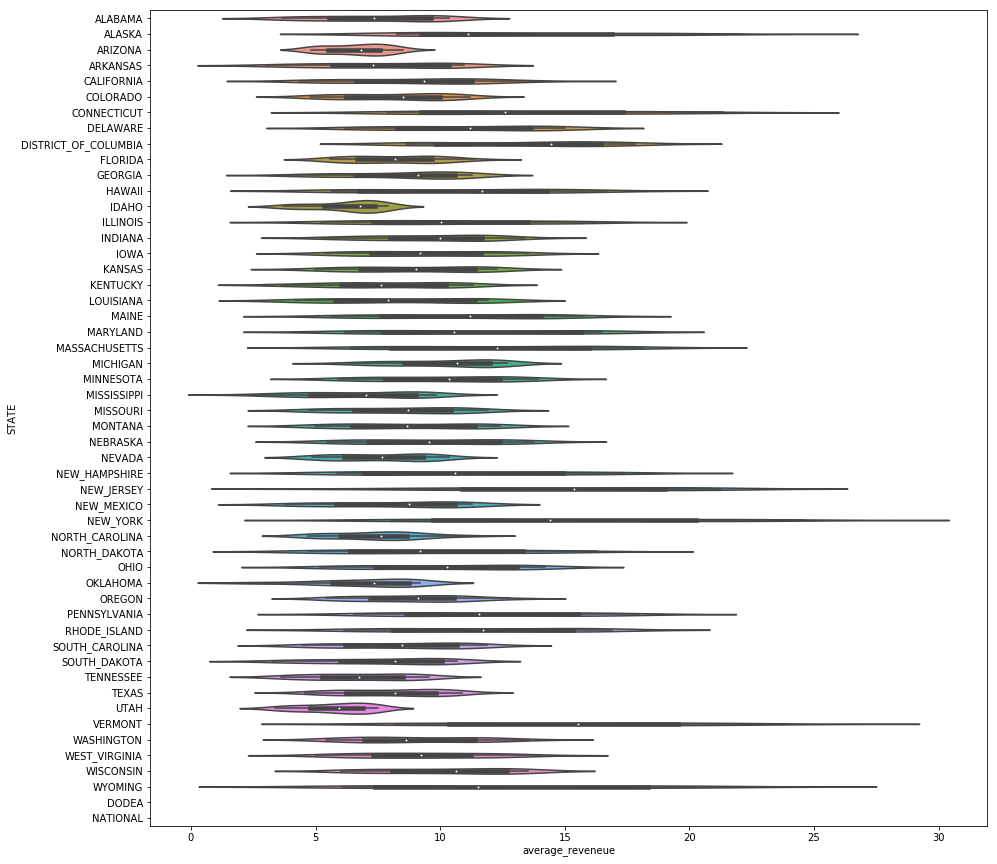

In [8]:
fig, ax = plt.subplots(figsize=(15, 15))
sns.violinplot(x="average_reveneue", y="STATE", data=df[df.STATE!='VIRGINIA'])

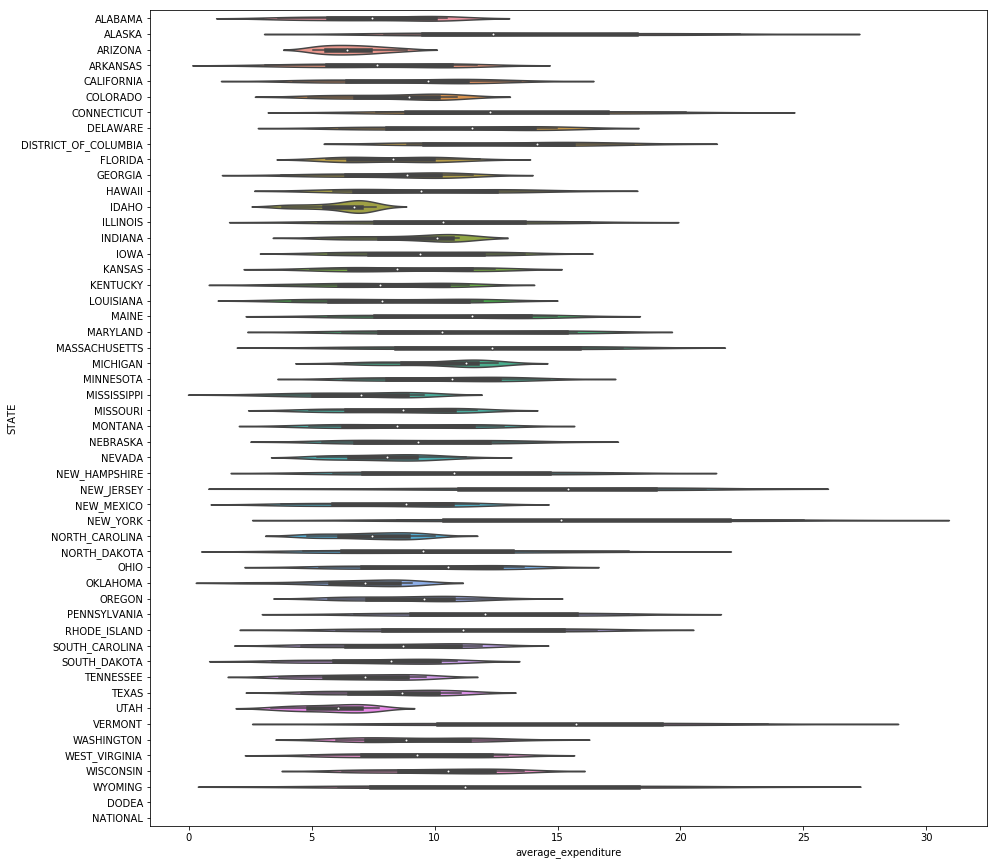

In [9]:
fig, ax = plt.subplots(figsize=(15, 15))
sns.violinplot(x="average_expenditure", y="STATE", data=df[df.STATE!='VIRGINIA'])

## Lets look on the influence of average cash on the exams

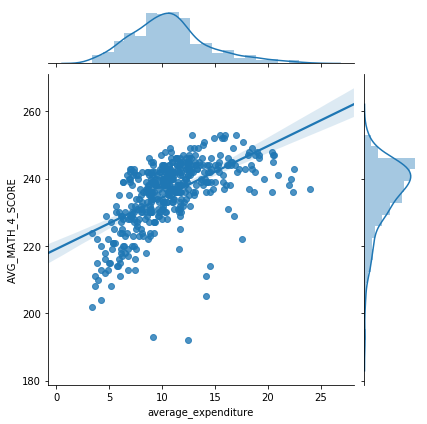

In [10]:
sns.jointplot("average_expenditure", "AVG_MATH_4_SCORE", data=df, kind="reg")

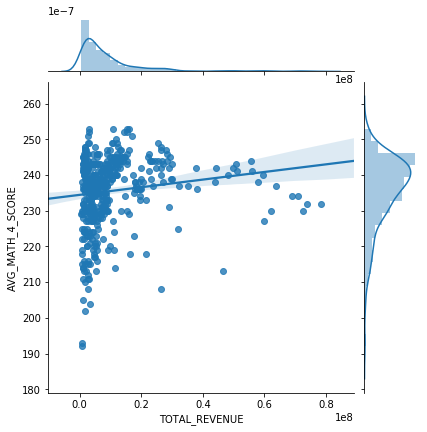

In [11]:
sns.jointplot("TOTAL_REVENUE", "AVG_MATH_4_SCORE", data=df, kind="reg")

## It looks like it makes difference if calculating money for all students and while making average for each student

## Creating model  for AVG_MATH_4_SCORE

In [14]:
df1=df.drop(['PRIMARY_KEY','AVG_MATH_8_SCORE','AVG_READING_4_SCORE','AVG_READING_8_SCORE','ENROLL'],axis=1)
df2=df1.dropna()
df3 = pd.get_dummies(df2, columns=['STATE'])
df4=(df3-df3.mean())/df3.std()

In [15]:
y=df4.loc[:,'AVG_MATH_4_SCORE'].values
X=df4.drop(['AVG_MATH_4_SCORE'],axis=1).loc[:,:].values

In [16]:
print(X.shape,' ',y.shape)

(395, 71)   (395,)


In [17]:
rf=RandomForestRegressor()

parameters = {'n_estimators': [4, 6, 9], 
              'max_features': ['log2', 'sqrt','auto'], 
              'max_depth': [2, 3, 5, 10], 
              'min_samples_split': [2, 3, 5],
              'min_samples_leaf': [1,5,8]
             }

# Run the grid search
grid_obj = GridSearchCV(rf, parameters, cv=5)
grid_obj = grid_obj.fit(X, y)

# Set the clf to the best combination of parameters
rf = grid_obj.best_estimator_

# Fit the best algorithm to the data. 
print('Params ',rf)
print('Score ',rf.score(X, y))

Params  RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=9, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)
Score  0.9156410540389677


## It is hard to fit X and y because X is multicolumn so i fit Y redict and y data- this shoud be stright line.

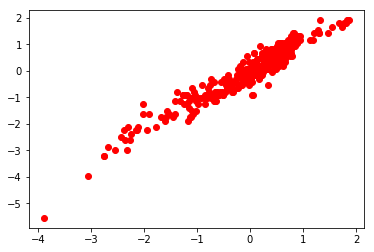

In [18]:
Y_rf=rf.predict(X)
plt.plot(Y_rf, y, 'ro')
plt.show()

In [19]:
feature_importances_rf = pd.DataFrame(rf.feature_importances_,
                                   index = df4.drop(['AVG_MATH_4_SCORE'],axis=1).columns,
                                    columns=['importance']).sort_values('importance',ascending=False)
feature_importances_rf.head()

,importance
YEAR,0.345013
average_reveneue,0.151835
average_expenditure,0.077163
GRADES_KG_G,0.042933
GRADES_4_G,0.037948


In [20]:
from sklearn.linear_model import Lasso, ElasticNet
clf = Lasso()

parameters = {'alpha': [0.00001,0.0001,0.001, 0.01],
              'tol': [0.00001,0.0001,0.001, 0.01]
             }

# Run the grid search
grid_obj = GridSearchCV(clf, parameters, cv=5)
grid_obj = grid_obj.fit(X, y)

# Set the clf to the best combination of parameters
clf = grid_obj.best_estimator_

# Fit the best algorithm to the data. 
print('Params ',clf)
print('Score ',clf.score(X, y))

Params  Lasso(alpha=1e-05, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=1e-05, warm_start=False)
Score  0.8742621656300812


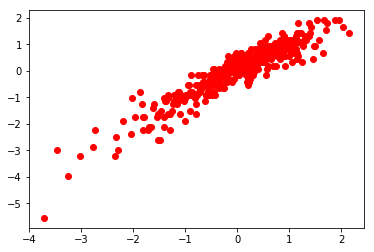

In [21]:
Y_clf=clf.predict(X)
plt.plot(Y_clf, y, 'ro')
plt.show()

In [22]:
feature_importances_clf = pd.DataFrame(clf.coef_,
                                   index = df4.drop(['AVG_MATH_4_SCORE'],axis=1).columns,
                                    columns=['importance']).sort_values('importance',ascending=False)
feature_importances_clf.head(10)

,importance
GRADES_8_G,2.231131
GRADES_9_12_G,1.828099
GRADES_KG_G,1.483461
YEAR,0.483930
LOCAL_REVENUE,0.358531
CAPITAL_OUTLAY_EXPENDITURE,0.336767
OTHER_EXPENDITURE,0.298771
average_expenditure,0.190671
STATE_NEW_HAMPSHIRE,0.179164
STATE_MASSACHUSETTS,0.177838


In [23]:
eln = ElasticNet()

parameters = {'alpha': [0.00001,0.0001,0.001, 0.01],
              'l1_ratio': [0.0001,0.001,0.01, 0.1],
              'tol': [0.00001,0.0001,0.001, 0.01],
              'max_iter': [1000,2000,5000, 10000],
             }

# Run the grid search
grid_obj = GridSearchCV(eln, parameters, cv=5)
grid_obj = grid_obj.fit(X, y)

# Set the clf to the best combination of parameters
eln = grid_obj.best_estimator_

# Fit the best algorithm to the data. 
print('Params ',eln)
print('Score ',eln.score(X, y))

Params  ElasticNet(alpha=1e-05, copy_X=True, fit_intercept=True, l1_ratio=0.0001,
      max_iter=2000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=1e-05, warm_start=False)
Score  0.8757004090968753


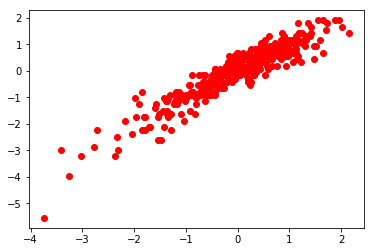

In [24]:
Y_eln=eln.predict(X)
plt.plot(Y_eln, y, 'ro')
plt.show()

## Lowest and highest value are best predicted by Random Forest, middle are simmilar for all models

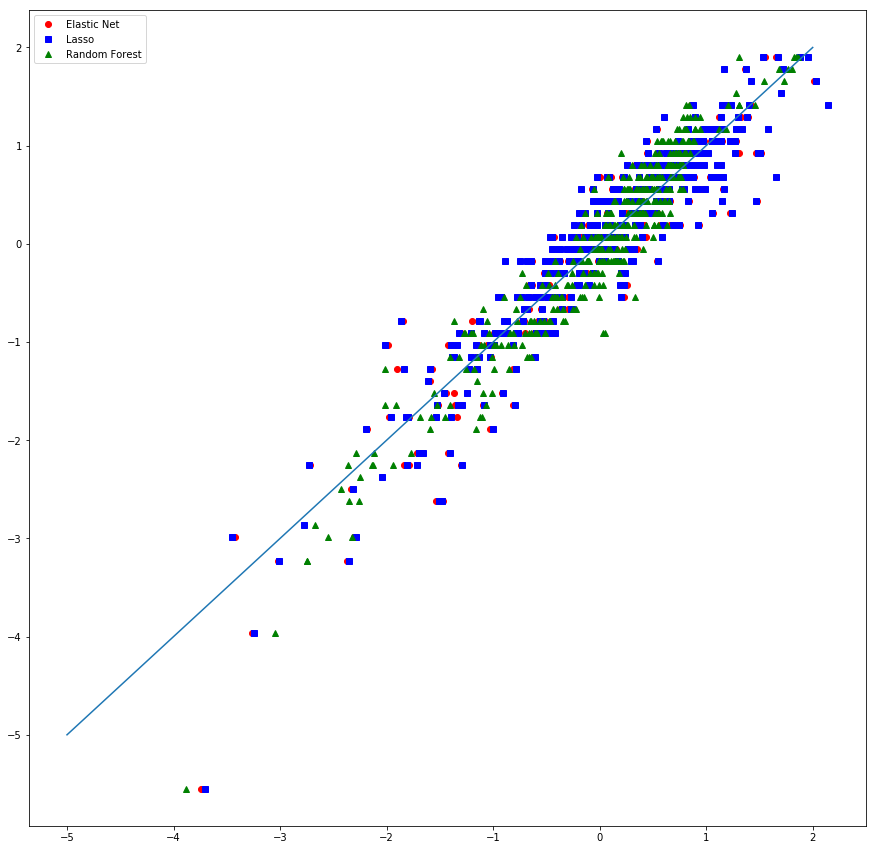

In [25]:
fig, ax = plt.subplots(figsize=(15, 15))
plt.plot(Y_eln, y, 'ro',label='Elastic Net')#red Elastic Net
plt.plot(Y_clf, y, 'bs',label='Lasso')#blue Lasso
plt.plot(Y_rf, y, 'g^',label='Random Forest')#green Random Forest
plt.plot([-5,2],[-5,2])#PREDICTION LIKE IT SHOUD BE
plt.legend()
plt.show()

In [26]:
feature_importances_eln = pd.DataFrame(eln.coef_,
                                   index = df4.drop(['AVG_MATH_4_SCORE'],axis=1).columns,
                                    columns=['importance']).sort_values('importance',ascending=False)
feature_importances_eln.head(10)

,importance
GRADES_9_12_G,2.466487
GRADES_8_G,2.226240
GRADES_KG_G,1.906860
YEAR,0.492833
CAPITAL_OUTLAY_EXPENDITURE,0.375894
OTHER_EXPENDITURE,0.354308
LOCAL_REVENUE,0.350862
INSTRUCTION_EXPENDITURE,0.330388
average_expenditure,0.221816
STATE_NEW_HAMPSHIRE,0.193663


* Non-linear Random Forest makes slightly better score than linear Lasso and Elastic Net. 
* From linear calculations highest influence on the math 4 exam have GRADES, year, expenditure and on 8th place average expenditure on student. This result is an exchange reason with effect. Analyze suggests the more trudents are at grades 9, 12 and 8 the better is 4th grade result. Correlation is the same but the REASON why there are many students in grade higher than 4th is that more of them passed exam. 
* Expenditure is more importand than revenue. In this cale RF is better for best and worst results so it may mean average revenue is more important for best and worst while expenditure for the rest.

## Influence of time:from correlation matrix we could see that there is an influence time on expenditure what makes more money for student in time

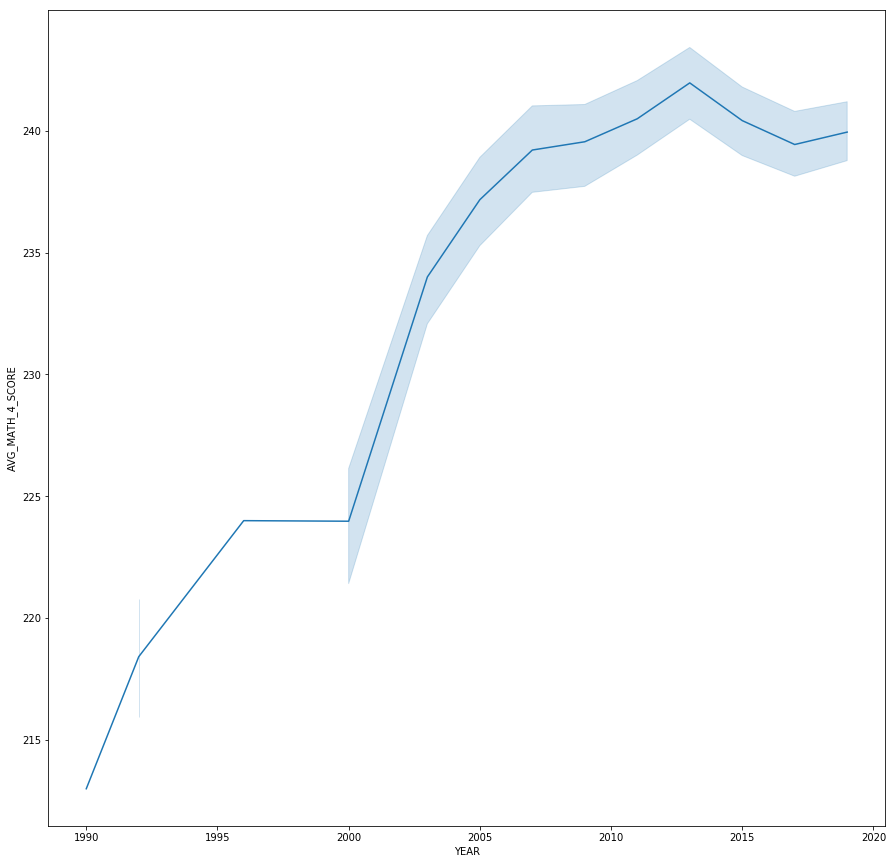

In [27]:
fig, ax = plt.subplots(figsize=(15, 15))
sns.lineplot(x="YEAR", y="AVG_MATH_4_SCORE", data=df)

## Building model for AVG_MATH_8_SCORE

In [28]:
df1=df.drop(['PRIMARY_KEY','AVG_MATH_4_SCORE','AVG_READING_4_SCORE','AVG_READING_8_SCORE','ENROLL'],axis=1)
df2=df1.dropna()
df3 = pd.get_dummies(df2, columns=['STATE'])
df4=(df3-df3.mean())/df3.std()

In [29]:
y=df4.loc[:,'AVG_MATH_8_SCORE'].values
X=df4.drop(['AVG_MATH_8_SCORE'],axis=1).loc[:,:].values

In [30]:
rf=RandomForestRegressor()

parameters = {'n_estimators': [4, 6, 9], 
              'max_features': ['log2', 'sqrt','auto'], 
              'max_depth': [2, 3, 5, 10], 
              'min_samples_split': [2, 3, 5],
              'min_samples_leaf': [1,5,8]
             }

# Run the grid search
grid_obj = GridSearchCV(rf, parameters, cv=5)
grid_obj = grid_obj.fit(X, y)

# Set the clf to the best combination of parameters
rf = grid_obj.best_estimator_

# Fit the best algorithm to the data. 
print('Params ',rf)
print('Score ',rf.score(X, y))

Params  RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
           max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=9, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)
Score  0.9273544337566532


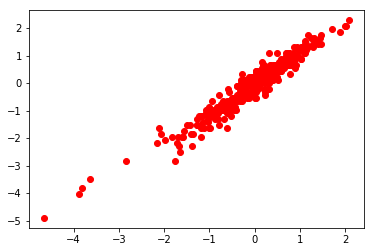

In [31]:
Y_rf=rf.predict(X)
plt.plot(Y_rf, y, 'ro')
plt.show()

In [32]:
feature_importances_rf = pd.DataFrame(rf.feature_importances_,
                                   index = df4.drop(['AVG_MATH_8_SCORE'],axis=1).columns,
                                    columns=['importance']).sort_values('importance',ascending=False)
feature_importances_rf.head()

,importance
average_expenditure,0.114818
GRADES_8_G,0.103472
GRADES_1_8_G,0.079483
YEAR,0.060704
OTHER_EXPENDITURE,0.054452


In [33]:
clf = Lasso()

parameters = {'alpha': [0.00001,0.0001,0.001, 0.01],
              'tol': [0.00001,0.0001,0.001, 0.01]
             }

# Run the grid search
grid_obj = GridSearchCV(clf, parameters, cv=5)
grid_obj = grid_obj.fit(X, y)

# Set the clf to the best combination of parameters
clf = grid_obj.best_estimator_

# Fit the best algorithm to the data. 
print('Params ',clf)
print('Score ',clf.score(X, y))

Params  Lasso(alpha=0.01, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.001, warm_start=False)
Score  0.9081002006111328


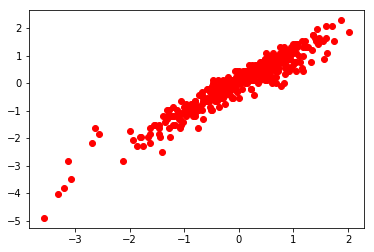

In [34]:
Y_clf=clf.predict(X)
plt.plot(Y_clf, y, 'ro')
plt.show()

In [35]:
feature_importances_clf = pd.DataFrame(clf.coef_,
                                   index = df4.drop(['AVG_MATH_8_SCORE'],axis=1).columns,
                                    columns=['importance']).sort_values('importance',ascending=False)
feature_importances_clf.head(10)

,importance
YEAR,0.247805
average_expenditure,0.188595
STATE_MASSACHUSETTS,0.151240
STATE_MINNESOTA,0.144173
STATE_NORTH_DAKOTA,0.095568
STATE_MONTANA,0.094540
STATE_NEW_HAMPSHIRE,0.086572
STATE_SOUTH_DAKOTA,0.077415
STATE_KANSAS,0.072468
STATE_VERMONT,0.057675


In [36]:
eln = ElasticNet()

parameters = {'alpha': [0.00001,0.0001,0.001, 0.01],
              'l1_ratio': [0.0001,0.001,0.01, 0.1],
              'tol': [0.00001,0.0001,0.001, 0.01],
              'max_iter': [1000,2000,5000, 10000],
             }

# Run the grid search
grid_obj = GridSearchCV(eln, parameters, cv=5)
grid_obj = grid_obj.fit(X, y)

# Set the clf to the best combination of parameters
eln = grid_obj.best_estimator_

# Fit the best algorithm to the data. 
print('Params ',eln)
print('Score ',eln.score(X, y))

Params  ElasticNet(alpha=0.01, copy_X=True, fit_intercept=True, l1_ratio=0.0001,
      max_iter=10000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False)
Score  0.9194340290561169


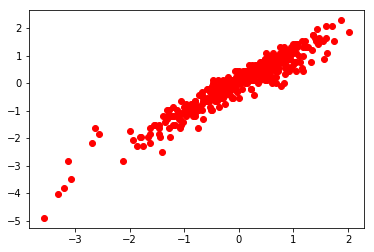

In [37]:
Y_eln=clf.predict(X)
plt.plot(Y_eln, y, 'ro')
plt.show()

In [38]:
feature_importances_eln = pd.DataFrame(eln.coef_,
                                   index = df4.drop(['AVG_MATH_8_SCORE'],axis=1).columns,
                                    columns=['importance']).sort_values('importance',ascending=False)
feature_importances_eln.head(10)

,importance
YEAR,0.244112
average_expenditure,0.219592
STATE_MASSACHUSETTS,0.206679
STATE_MINNESOTA,0.183070
OTHER_EXPENDITURE,0.142874
STATE_MONTANA,0.141340
STATE_NORTH_DAKOTA,0.141045
STATE_NEW_HAMPSHIRE,0.136059
FEDERAL_REVENUE,0.121773
STATE_SOUTH_DAKOTA,0.119448


Result is simmilar. RF is best but not significantly for lowest and highest results.

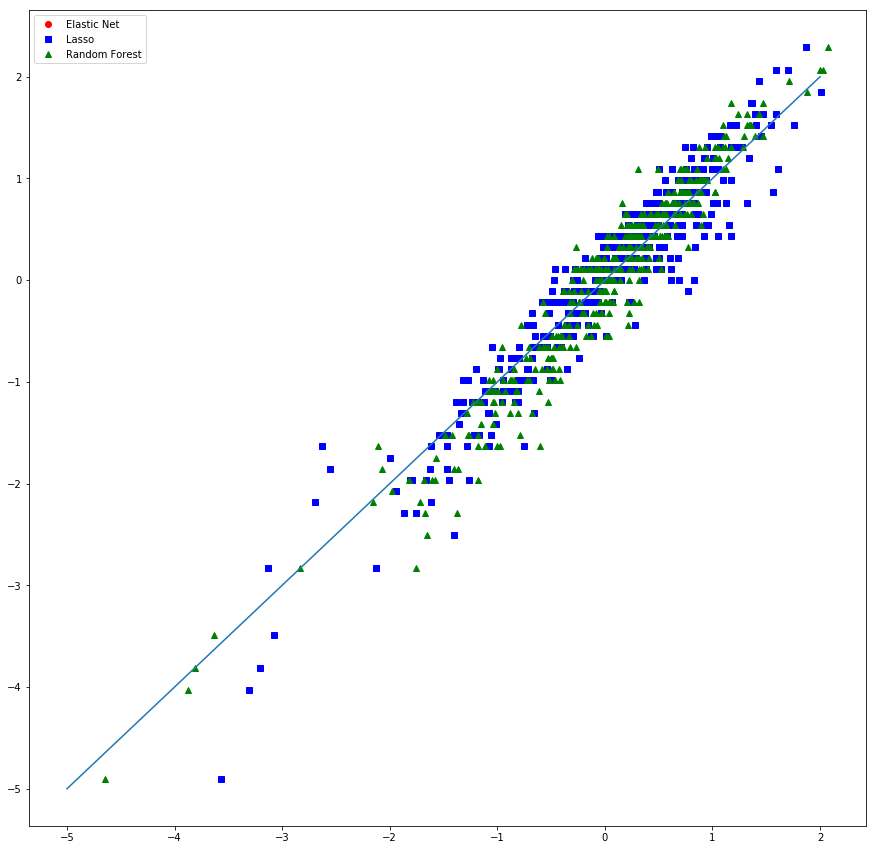

In [39]:
fig, ax = plt.subplots(figsize=(15, 15))
plt.plot(Y_eln, y, 'ro',label='Elastic Net')#red Elastic Net
plt.plot(Y_clf, y, 'bs',label='Lasso')#blue Lasso
plt.plot(Y_rf, y, 'g^',label='Random Forest')#green Random Forest
plt.plot([-5,2],[-5,2])#PREDICTION LIKE IT SHOUD BE
plt.legend()
plt.show()

* If RF is best for worst and best students in this area most important are money-calculated averages
* for other students most important is where are they studying- the STATE
* it means (what was already shown) each STATE gives slightly different sum of money for each student
* . MASSACHUSETT gives highest part, then MINESOTA, NORTH DACOTA
* good correlation are for states given highest part, so RF works better for wors students that best students. IN this case average money plays most important role

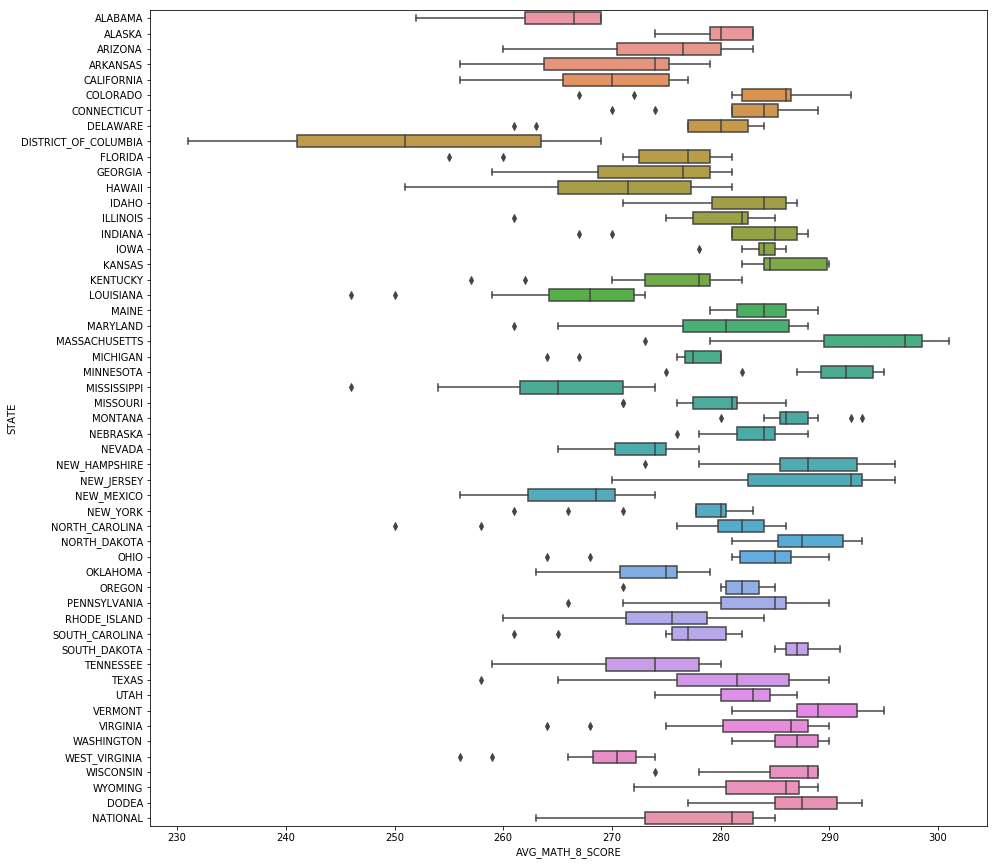

In [40]:
fig, ax = plt.subplots(figsize=(15, 15))
sns.boxplot(x="AVG_MATH_8_SCORE", y="STATE", data=df)

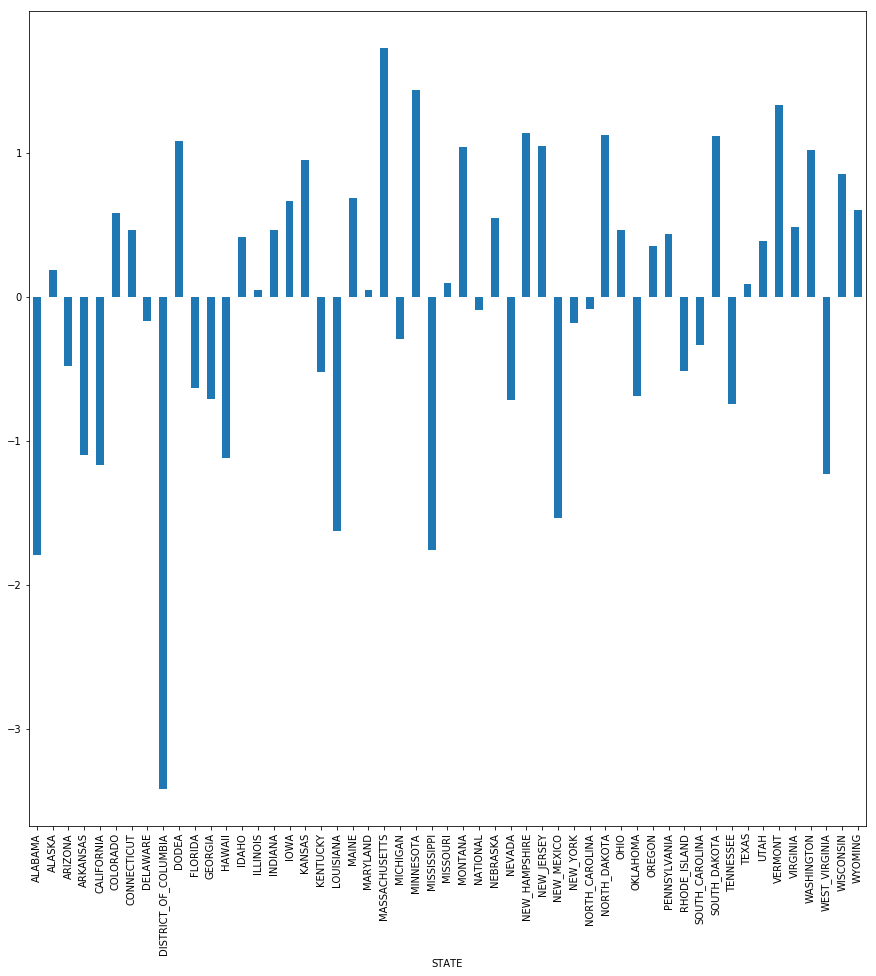

In [41]:
states=df.groupby(['STATE']).mean()
normalized_df=(states-states.mean())/states.std()
fig, ax = plt.subplots(figsize=(15, 15))
normalized_df['AVG_MATH_8_SCORE'].plot(kind='bar');